_Lambda School Data Science, Unit 2_
 
# Regression 1 Sprint Challenge

Your Sprint Challenge has two parts.

To demonstrate mastery on each part, do all the required, numbered instructions. 

To earn a score of "3" for the part, also do the stretch goals.

## Part 1. Predict avocado sales 🥑

For part 1 of your challenge, you'll use historical data on avocado sales across the nation!

Run this code cell to load the dataset. It has weekly sales volume (total number of avocados sold) from January 4, 2015 through March 25, 2018. The data comes directly from retailers' cash registers based on actual retail sales of Hass avocados in multiple US markets.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
avocado_url = 'https://drive.google.com/uc?export=download&id=1ljE-LhCA9CCFvSIJYJ1ewX8JmdDpfuhi'
avocado = pd.read_csv(avocado_url)
assert avocado.shape == (169, 2)

In [21]:
#Imports 
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [3]:
pd.plotting.register_matplotlib_converters()

In [4]:
avocado.head()

,Date,Total Volume
0,2015-01-04,84674288
1,2015-01-11,78555753
2,2015-01-18,78388735
3,2015-01-25,76466226
4,2015-02-01,119453181


### Required

#### Use the Prophet library to:
1. Fit a model and forecast avocado sales through March 25, 2020
2. Plot the forecast
3. Plot the forecast components
4. Do time series cross-validation, with these parameters: `horizon='90 days', period='45 days', initial='730 days'`
5. Plot the cross-validation Mean Absolute Percentage Error: `metric='mape'`

_For Part 1 of this Sprint Challenge, you are **not** required to calculate or plot baselines, or do train/test split._

You can be confident you've done it correctly when your plots look similar to these:

<img src="https://i.imgur.com/PoyVGp7.png" width="400" align="left">



In [5]:
avocado = avocado.rename(columns={'Date':'ds', 'Total Volume': 'y'})
avocado.head()

,ds,y
0,2015-01-04,84674288
1,2015-01-11,78555753
2,2015-01-18,78388735
3,2015-01-25,76466226
4,2015-02-01,119453181


### Fit a model and forecast avocado sales through March 25, 2020

In [24]:
m = Prophet(daily_seasonality=False)

In [25]:
m.fit(avocado)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [26]:
future = m.make_future_dataframe(periods=732)

In [27]:
forecast = m.predict(future)

### Plot the forecast

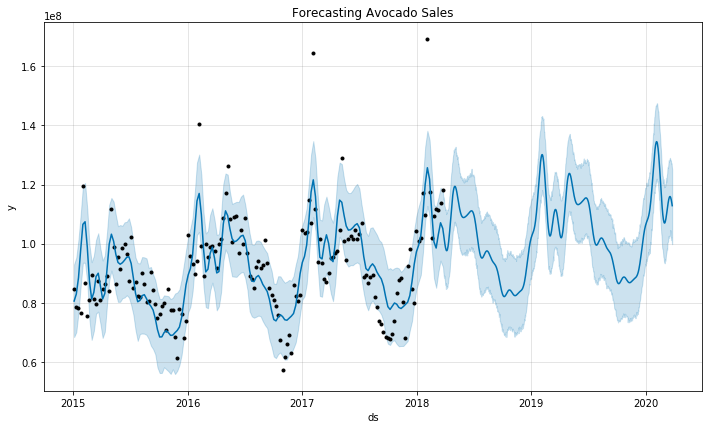

In [19]:
fig1 = m.plot(forecast)
plt.title('Forecasting Avocado Sales');

### Plot the forecast components

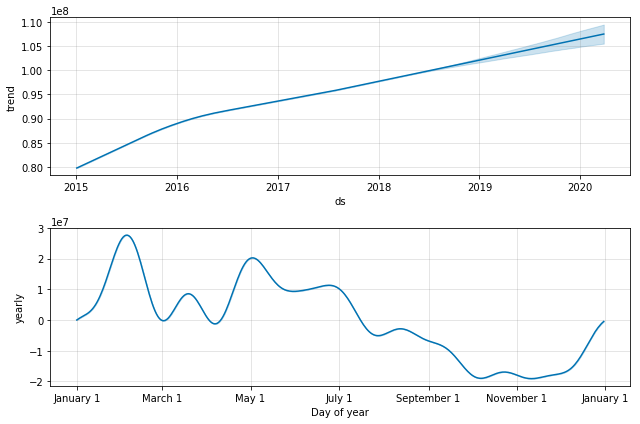

In [18]:
fig2 = m.plot_components(forecast)

### Time series cross-validation

In [28]:
df_cv = cross_validation(m, horizon='90 days', period='45 days', initial='730 days')
performance_metrics(df_cv).head()

INFO:fbprophet:Making 8 forecasts with cutoffs between 2017-02-13 00:00:00 and 2017-12-25 00:00:00


,horizon,mse,rmse,mae,mape,coverage
0,9 days,1.160951e+14,1.077475e+07,9.057276e+06,0.102888,0.5
1,10 days,1.156367e+14,1.075345e+07,8.960854e+06,0.101672,0.5
2,11 days,8.989209e+13,9.481144e+06,7.981286e+06,0.088973,0.6
3,12 days,9.502117e+13,9.747880e+06,8.666280e+06,0.099210,0.6
4,13 days,9.555187e+13,9.775064e+06,8.875647e+06,0.097985,0.6


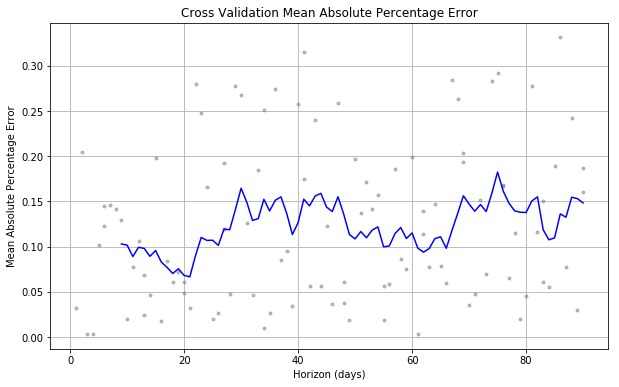

In [15]:
fig3 = plot_cross_validation_metric(df_cv, metric='mape')
plt.ylabel('Mean Absolute Percentage Error')
plt.title('Cross Validation Mean Absolute Percentage Error');

### Stretch Goal
- Adjust your forecasts with Prophet's options for changepoints, holidays, and fourier order. Improve the cross-validation MAPE.

In [29]:
#Create holidays 
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))

In [30]:
m = Prophet(daily_seasonality=False, yearly_seasonality=10, holidays = holidays)
m.fit(avocado)
df_cv = cross_validation(m, horizon='90 days', period='45 days', initial='730 days')
performance_metrics(df_cv).head()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2017-02-13 00:00:00 and 2017-12-25 00:00:00


,horizon,mse,rmse,mae,mape,coverage
0,9 days,1.153821e+14,1.074161e+07,9.094411e+06,0.103331,0.5
1,10 days,1.152254e+14,1.073431e+07,9.066239e+06,0.102825,0.5
2,11 days,8.743670e+13,9.350759e+06,8.033967e+06,0.089519,0.6
3,12 days,9.101830e+13,9.540351e+06,8.542705e+06,0.097434,0.6
4,13 days,8.866317e+13,9.416112e+06,8.400623e+06,0.092979,0.6


## Part 2. Predict NYC apartment rent 🏠💸

For part 1 of your challenge, you'll use a real-world data with rent prices for a subset of apartments in New York City!

Run this code cell to load the dataset: 

### Required
1. Begin with baselines for regression. Calculate the mean absolute error and $R^2$ score for a mean baseline. _(You can use the whole dataset, or a test set, either way is okay here!)_
2. Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
3. Choose any two features.
4. Use scikit-learn to fit a Linear Regression model on the train data.
5. Apply the model to predict rent prices for the test data.
6. Get regression metrics MAE and $R^2$ for the test data.
7. Get the model's coefficients and intercept.

### Stretch Goals
- Try at least 3 different feature combinations. (You don't have to use two features, you can choose any number of features.)
- Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.

In [44]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

In [31]:
import pandas as pd
rent_url = 'https://drive.google.com/uc?export=download&id=1lVVPmh-WYGb_0Gs_lOv22i02-150qDdZ'
rent = pd.read_csv(rent_url)
assert rent.shape == (48295, 7)

In [32]:
rent.head()

,year,month,bedrooms,bathrooms,latitude,longitude,price
0,2016,6,3,1.5,40.7145,-73.9425,3000
1,2016,6,2,1.0,40.7947,-73.9667,5465
2,2016,4,1,1.0,40.7388,-74.0018,2850
3,2016,4,1,1.0,40.7539,-73.9677,3275
4,2016,4,4,1.0,40.8241,-73.9493,3350


### Calculate the mean absolute error and  𝑅2  score for a mean baseline

In [37]:
rent['mean_baseline'] = rent['price'].mean()
y = rent['price']

mae = mean_absolute_error(y, rent['mean_baseline'] )
r2 = r2_score(y, rent['mean_baseline'])
print('Mean Absolute Error:', mae)
print('R^2:', r2)

Mean Absolute Error: 1055.7857771080928
R^2: 0.0


### Test Train Split
Training data: April & May 2016  
Testing data: June 2016

In [39]:
train = rent[rent['month'] < 6]
test = rent[rent['month']==6]

features = ['latitude', 'bedrooms']
target = 'price'

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

### Fit a Linear Regression model on the train data

In [40]:
model = LinearRegression()

In [41]:
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

### Apply the model to predict rent prices for the test data

In [42]:
y_pred = model.predict(X_test)
y_pred

array([4619.80812621, 3674.63712288, 2811.95886819, ..., 3025.45339045,
       3671.8965    , 3817.42357486])

### Get regression metrics MAE and $R^2$ for the test data

In [43]:
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))

Mean Absolute Error: 857.7191386483174
R2: 0.2984588794462183


### Get the model's coefficients and intercept

In [284]:
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)

Coefficients: [-2740.62287881   725.37304845]
Intercept: 114026.77918031707


### Stretch Goal
Try at least 3 different feature combinations. (You don't have to use two features, you can choose any number of features.)
Get regression metrics RMSE, MAE, and  𝑅2 , for both the train and test data.

In [75]:
def stretch(X_train, y_train, X_test, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)        
    rmse = mean_squared_error(y_test,y_pred)
    result_dict = {'mae':mae,'r2':r2,'rmse':rmse}
    return result_dict

In [83]:
train = rent[rent['month'] < 6]
test = rent[rent['month']==6]

In [71]:
features = ['bedrooms', 'bathrooms']
target = 'price'

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [82]:
m = stretch(X_train, y_train, X_test, y_test)

print(f'Bed/Bath:\nMAE: {m["mae"]}, R^2:{m["r2"]}, RMSE: {m["rmse"]}')   

Bed/Bath:
MAE: 754.0733041489015, R^2:0.46135848519077227, RMSE: 1064677.9566947015


In [86]:
features = ['latitude', 'bedrooms', 'bathrooms']
target = 'price'

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [87]:
m = stretch(X_train, y_train, X_test, y_test)

print(f'Lat/Bed/Bath:\nMAE: {m["mae"]}, R^2:{m["r2"]}, RMSE: {m["rmse"]}')   

Lat/Bed/Bath:
MAE: 746.7235225517652, R^2:0.464997329497829, RMSE: 1057485.422857165
